## Audio Data Exploration

In [1]:
from datasets import load_dataset_builder

In [2]:
ds_builder = load_dataset_builder(
    "openslr/librispeech_asr", trust_remote_code=True
)
ds_builder.info.splits

{'train.clean.100': SplitInfo(name='train.clean.100', num_bytes=6627791685, num_examples=28539, shard_lengths=None, dataset_name=None),
 'train.clean.360': SplitInfo(name='train.clean.360', num_bytes=23927767570, num_examples=104014, shard_lengths=None, dataset_name=None),
 'train.other.500': SplitInfo(name='train.other.500', num_bytes=31852502880, num_examples=148688, shard_lengths=None, dataset_name=None),
 'validation.clean': SplitInfo(name='validation.clean', num_bytes=359505691, num_examples=2703, shard_lengths=None, dataset_name=None),
 'validation.other': SplitInfo(name='validation.other', num_bytes=337213112, num_examples=2864, shard_lengths=None, dataset_name=None),
 'test.clean': SplitInfo(name='test.clean', num_bytes=368449831, num_examples=2620, shard_lengths=None, dataset_name=None),
 'test.other': SplitInfo(name='test.other', num_bytes=353231518, num_examples=2939, shard_lengths=None, dataset_name=None)}

In [3]:
ds_builder.info.features

{'file': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'text': Value(dtype='string', id=None),
 'speaker_id': Value(dtype='int64', id=None),
 'chapter_id': Value(dtype='int64', id=None),
 'id': Value(dtype='string', id=None)}

In [4]:
from datasets import load_dataset

In [5]:
ds = load_dataset(
    "openslr/librispeech_asr",
    split="train.clean.360",
    streaming=True
)

sample = next(iter(ds))
sample

{'file': '1487-133273-0000.flac',
 'audio': {'path': '1487-133273-0000.flac',
  'array': array([ 9.15527344e-05,  4.57763672e-04,  5.18798828e-04, ...,
         -4.57763672e-04, -5.49316406e-04, -4.88281250e-04]),
  'sampling_rate': 16000},
 'text': 'THE SECOND IN IMPORTANCE IS AS FOLLOWS SOVEREIGNTY MAY BE DEFINED TO BE THE RIGHT OF MAKING LAWS IN FRANCE THE KING REALLY EXERCISES A PORTION OF THE SOVEREIGN POWER SINCE THE LAWS HAVE NO WEIGHT',
 'speaker_id': 1487,
 'chapter_id': 133273,
 'id': '1487-133273-0000'}

In [6]:
array = sample["audio"]['array']
sampling_rate = sample['audio']['sampling_rate']

array = array[: sampling_rate * 5]
print(f"Number of samples: {len(array)}. Values: {array}")

Number of samples: 80000. Values: [9.15527344e-05 4.57763672e-04 5.18798828e-04 ... 7.05261230e-02
 5.92041016e-02 6.50329590e-02]


In [7]:
import IPython.display as ipd

In [8]:
ipd.Audio(data=array, rate=sampling_rate)

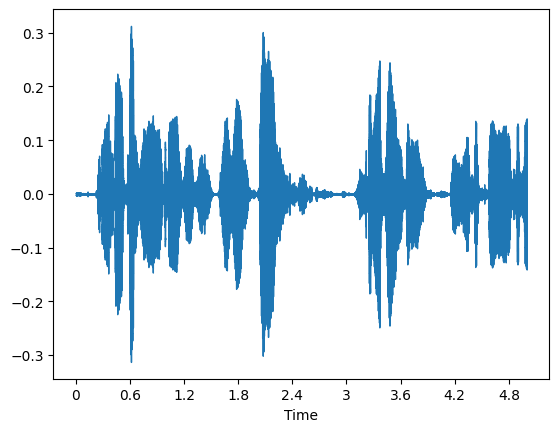

In [9]:
import librosa.display

librosa.display.waveshow(array, sr=sampling_rate)

## Wave Exploration

In [10]:
import numpy as np
from matplotlib import pyplot as plt

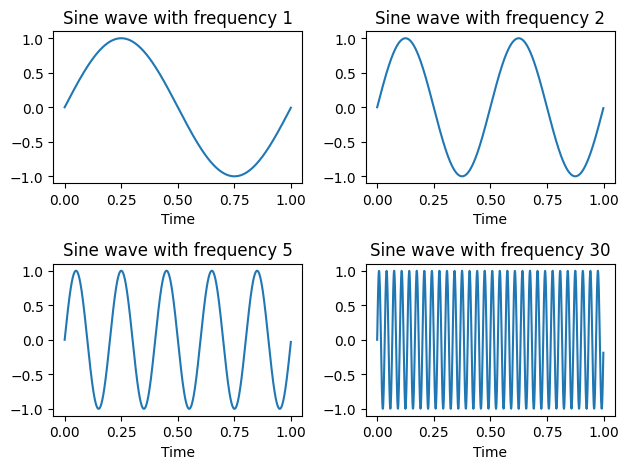

In [11]:
def plot_sine(freq):
    sr = 1000
    ts = 1.0 / sr
    t = np.arange(0, 1, ts)
    amplitude = np.sin(2 * np.pi * freq * t)

    plt.plot(t, amplitude)
    plt.title("Sine wave with frequency {}".format(freq))
    plt.xlabel("Time")

fig = plt.figure()

plt.subplot(2, 2, 1)
plot_sine(1)

plt.subplot(2, 2, 2)
plot_sine(2)

plt.subplot(2, 2, 3)
plot_sine(5)

plt.subplot(2, 2, 4)
plot_sine(30)

fig.tight_layout()
plt.show()

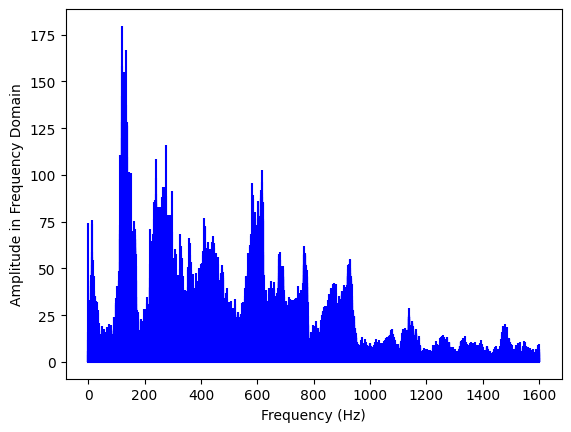

In [12]:
X = np.fft.fft(array)
N = len(X)
n = np.arange(N)
T = N / sampling_rate
freq = n / T
plt.stem(freq[:8000], np.abs(X[:8000]), "b", markerfmt=" ", basefmt="-b")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude in Frequency Domain")
plt.show()

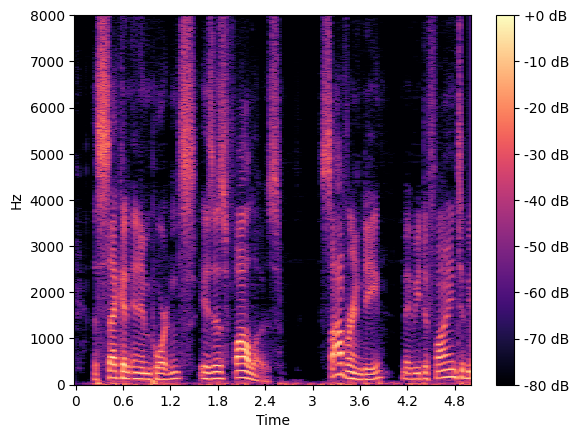

In [13]:
D = np.abs(librosa.stft(array))
S_db = librosa.amplitude_to_db(D, ref=np.max)

librosa.display.specshow(S_db, sr=sampling_rate, x_axis="time", y_axis="hz")
plt.colorbar(format="%+2.0f dB")

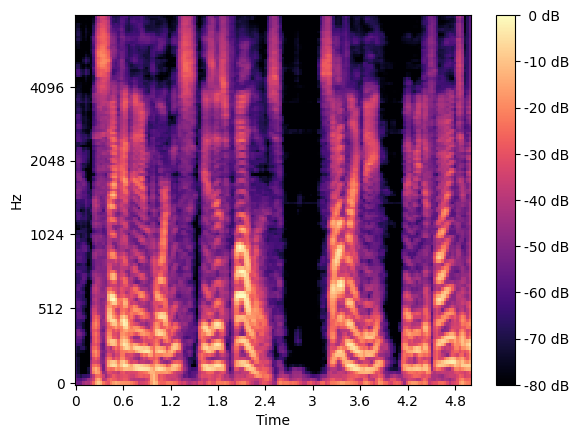

In [14]:
S = librosa.feature.melspectrogram(y=array, sr=sampling_rate)

S_dB = librosa.power_to_db(S, ref=np.max)

librosa.display.specshow(S_dB, sr=sampling_rate, x_axis="time", y_axis="mel")
plt.colorbar(format="%2.0f dB")

# Speech to Text

In [15]:
from transformers import pipeline

pipe = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-small",
    max_new_tokens=200
)
pipe(array)

Device set to use mps:0
/Users/jorocca/Desktop/Projects/AI Practice/Transformers-Diffusions/.venv/lib/python3.10/site-packages/transformers/pipelines/automatic_speech_recognition.py:312: FutureWarning: `max_new_tokens` is deprecated and will be removed in version 4.49 of Transformers. To remove this warning, pass `max_new_tokens` as a key inside `generate_kwargs` instead.
  warnings.warn(
/Users/jorocca/Desktop/Projects/AI Practice/Transformers-Diffusions/.venv/lib/python3.10/site-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, ma

{'text': ' The second in importance is as follows. Sovereignty may be defined to be'}

In [16]:
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from genaibook.core import get_device

In [17]:
device = get_device()

In [18]:
wav2vec2_processor = Wav2Vec2Processor.from_pretrained(
    "facebook/wav2vec2-base-960h"
)
wav2vec2_model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base-960h"
).to(device)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
inputs = wav2vec2_processor(
    array, sampling_rate=sampling_rate, return_tensors="pt"
)

In [24]:
with torch.inference_mode():
    outputs = wav2vec2_model(**inputs.to(device))

In [25]:
predicted_ids = torch.argmax(outputs.logits, dim=-1)
transcription = wav2vec2_processor.batch_decode(predicted_ids)
print(transcription)

['THE SECOND IN IMPORTANCE IS AS FOLLOWS SOVEREIGNTY MAY BE DEFINED TO']


In [26]:
from transformers import WhisperTokenizer

In [27]:
tokenizer = WhisperTokenizer.from_pretrained(
    "openai/whisper-small", language="Spanish", task="transcribe"
)

In [29]:
input_string = "Hola, cómo estás?"
labels = tokenizer(input_string).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input: {input_string}")
print(f"Formatted Input w/ special: {decoded_with_special}")
print(f"Formatted w/o special: {decoded_str}")

Input: Hola, cómo estás?
Formatted Input w/ special: <|startoftranscript|><|es|><|transcribe|><|notimestamps|>Hola, cómo estás?<|endoftext|>
Formatted w/o special: Hola, cómo estás?


In [30]:
from transformers import WhisperForConditionalGeneration, WhisperProcessor

In [31]:
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-small")
whisper_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device)

In [36]:
inputs = whisper_processor(array, sampling_rate=sampling_rate, return_tensors="pt")

In [37]:
with torch.inference_mode():
    generated_ids = whisper_model.generate(**inputs.to(device))

In [38]:
transcription = whisper_processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
print(transcription)

 The second in importance is as follows. Sovereignty may be defined to be


In [39]:
from genaibook.core import generate_long_audio
long_audio = generate_long_audio()

README.md:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

librispeech_asr.py:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

In [40]:
pipe = pipeline("automatic-speech-recognition", model="openai/whisper-small", device=device)
pipe(
    long_audio,
    generate_kwargs={"task": "transcribe"},
    chunk_length_s=5, # Used for longer audio
    batch_size=8,
    return_timestamps=True
)

Device set to use mps
/Users/jorocca/Desktop/Projects/AI Practice/Transformers-Diffusions/.venv/lib/python3.10/site-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.


{'text': ' the second in importance is as follows. Sovereignty may be defined to be the right of making laws. In France, the king really exercises a portion of the sovereign power, since the laws have no weight till he has given his assent to them. He is moreover the executor of the laws, but he does not really cooperate in their formation since the refusal of his asset does not annul them. He is therefore merely to be considered as the agent of the sovereign power. But not only does the king of France exercise a portion of the sovereign power, he also contributes to the nomination of the legislature, which exercises the other portion. He has the privilege of appointing the members of one chamber and of dissolving the United States has no share in the formation of the legislative body and cannot dissolve any part of it. The king has the same right of bringing forward measures as the chambers. A right which the president does not possess.',
 'chunks': [{'timestamp': (0.0, 3.0),
   'text

### Evaluating Speech to Text Models
- Compare facebook to open ai model

In [ ]:
# Run this cell in Google Colab - no Mac
from genaibook.core import measure_latency_and_memory_use

wav2vec2_pipe = pipeline(
    "automatic-speech-recognition",
    model="facebook/wav2vec2-base-960h",
    device=device
)
whisper_pipe = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-base",
    device=device
)

with torch.inference_mode():
    measure_latency_and_memory_use(
        wav2vec2_pipe, array, "Wav2Vec2", device, nb_loops=100
    )
    measure_latency_and_memory_use(
        whisper_pipe, array, "Whisper", device=device, nb_loops=100
    )

In [ ]:
# Word Error Rate - can also do Character Error Rate, but WER is more common
from evaluate import load

In [47]:
wer_metric = load("wer")

In [48]:
label = "how can the llama jump"
pred = "can the lama jump up"
wer = wer_metric.compute(references=[label], predictions=[pred])

print(wer)

0.6


In [49]:
# Normalize punctuation and spacing
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

normalizer = BasicTextNormalizer()
print(normalizer("I'm having a great day!"))

i m having a great day 


In [50]:
# WER and CER in different languages (English and French)
from datasets import Audio

In [51]:
def normalize(batch):
    batch['norm_text'] = normalizer(batch["sentence"])
    return batch

In [59]:
def prepare_dataset(language="en", sample_count=200):
    dataset = load_dataset(
        "mozilla-foundation/common_voice_13_0",
        language,
        split="test",
        streaming=True,
        trust_remote_code=True
    )
    dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
    dataset = dataset.take(sample_count)
    buffered_dataset = [sample for sample in dataset.map(normalize)]
    return buffered_dataset

In [53]:
def evaluate_model(pipe, dataset, lang="en", use_whisper=False):
    predictions, references = [], []

    for sample in dataset:
        if use_whisper:
            extra_kwargs = {
                "task": "transcribe",
                "language": f"<|{lang}|>",
                "max_new_tokens": 100
            }
            transcription = pipe(
                sample["audio"]["array"],
                return_timestamps=True,
                generate_kwargs=extra_kwargs
            )
        else:
            transcription = pipe(sample["audio"]["array"])
        predictions.append(normalizer(transcription["text"]))
        references.append(sample["norm_text"])
    return predictions, references

In [55]:
eval_suite = [
    ["Wave2Vec2", wav2vec2_pipe, "en"],
    ["Wave2Vec2", wav2vec2_pipe, "fr"],
    ["Whisper", whisper_pipe, "en"],
    ["Whisper", whisper_pipe, "fr"]
]

In [60]:
cer_metric = load("cer")
processed_datasets = {
    "en": prepare_dataset("en"),
    "fr": prepare_dataset("fr")
}

for config in eval_suite:
    model_name, pipeline, lang = config[0], config[1], config[2]
    dataset = processed_datasets[lang]
    predictions, references = evaluate_model(
        pipeline, dataset, lang, model_name == "Whisper"
    )
    wer = wer_metric.compute(references=references, predictions=predictions)
    cer = cer_metric.compute(references=references, predictions=predictions)

    print(f"{model_name} metrics for lang: {lang}. WER: {wer}, CER: {cer}")

Reading metadata...: 16372it [00:00, 16535.35it/s]
Reading metadata...: 16114it [00:00, 17847.89it/s]


Wave2Vec2 metrics for lang: en. WER: 0.44012772751463547, CER: 0.22138524750538055
Wave2Vec2 metrics for lang: fr. WER: 1.0099113197704748, CER: 0.5745033112582781


/Users/jorocca/Desktop/Projects/AI Practice/Transformers-Diffusions/.venv/lib/python3.10/site-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


Whisper metrics for lang: en. WER: 0.2687599787120809, CER: 0.14674232048522795


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


Whisper metrics for lang: fr. WER: 0.5211267605633803, CER: 0.2573583517292127
